In [1]:
# Se importan las librerías necesarias para poder capturar los datos,
# generar el dataset y hacer un primer análisis exploratorio
from requests import get
from bs4 import BeautifulSoup
from datetime import date, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Se define la URL de donde se van a obtener los datos
url = 'https://www.worldometers.info/coronavirus/'
# Se guarda la fecha de ayer en una variable
timestamp = (date.today() - timedelta(days=1)).strftime("%Y-%m-%d")
# Se genera un diccionario vacio donde se almacenaran los datos
_dict = {}
# Se define una variable para activar el guardado del dataset en un csv
save_csv = True
# Se define otra variable para concatenar datos en el csv
append_csv = True
# Se define el percentil de casos sobre el que han de estar los paises
# para mostrarlos en el análisis exploratorio
percentile = 97

In [3]:
# Se obtiene el contenido de la web
page = get(url).content
# Se convierte el contenido en un objeto tipo BeautifulSoup
soup = BeautifulSoup(page)

In [4]:
# Se navega por el objeto soup en busca de todos los tags 'div'
# Para cada uno de los tags 'div'
for _div in soup.find_all('div'):
    # Para cada  uno de los atributos del tag 'div'
    for _attr in _div.attrs:
        # Si el nombre del atributo es 'id'
        if _attr == 'id':
            # Si el valor del atributo 'id' es 'nav-yesterday'
            # De esta manera se obtienen los dato de ayer,
            # asegurando que los datos estan lo más actualizados posible para ese día
            if _div['id'] == 'nav-yesterday':
                # Para cada uno de los tags tr (fila) de dentro del tag tbody (tabla)
                for _tr in _div.tbody.find_all('tr'):
                    for i, _td in enumerate(_tr.find_all('td')):  
                        # Siempre que el índice de la fila sea divisible por 10 
                        # (la tabla tiene 10 atributos)
                        # Se recupera el primer atributo que corresponde al país
                        if i%10 == 0:
                            _a = _td.find('a')
                            # En el caso de qe el nombre del país sea de los que se muestra como un enlace
                            if _a:
                                # Se obtiene el nombre del país
                                country_name = _a['href'].split('/')[1]
                            # En el caso contrario
                            else:
                                _span = _td.find('span')
                                # Si es de los que se muestran en dos filas
                                if _span:
                                    # Se obtiene el nombre del país
                                    country_name = _span.contents[0]
                                # En caso contrario
                                else:
                                     # Se obtiene el nombre del país
                                    country_name = _td.contents[0]
                            # En caso de haber obtenido el nombre del país
                            if country_name:
                                # Se eliminan espacios innecesarios
                                country_name = country_name.strip()
                                # Si los datos del país no han sido añadidos al diccionario
                                if country_name not in list(_dict.keys()):
                                    # Se añade al diccionario una entrada por el país
                                    _dict[country_name] = {} 
                                # Para ese país, se añade la fecha del dato
                                _dict[country_name][timestamp] = []
                        # Para el resto de filas (que corresponden a los datos de cada país)
                        else:
                            # Si contiene datos
                            if len(_td.contents) > 0:
                                # Se limpia el dato de cualquier símbolo para poder convertirlo en un valor numérico
                                data = _td.contents[0].replace('+','').replace(',','').strip()
                                # Si el dato contiene un valor
                                if data:
                                    # Se almacena como número en el diccionario
                                    _dict[country_name][timestamp].append(float(data))
                                # En caso contrario
                                else:
                                    # Se almacena un 0 en el diccionario
                                    _dict[country_name][timestamp].append(0)
                            # En caso contrario
                            else:
                                # Se almacena un 0 en el diccionario
                                _dict[country_name][timestamp].append(0)          

In [5]:
# Se genera un DataFrame a partir del diccionario que contiene los datos
# https://stackoverflow.com/questions/13575090/construct-pandas-dataframe-from-items-in-nested-dictionary
df = pd.concat({k: pd.DataFrame(v).T for k, v in _dict.items()}, axis=0)
df.columns = ['total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'total_recovered', 'active_cases', 'servious_critical', 'total_cases_1M_pop', 'total_deaths_1M_pop']
df.index.names = ['country', 'date']
display(df.head())

,,total_cases,new_cases,total_deaths,new_deaths,total_recovered,active_cases,servious_critical,total_cases_1M_pop,total_deaths_1M_pop
country,date,,,,,,,,,
Afghanistan,2020-03-25,84.0,10.0,2.0,1.0,2.0,80.0,0.0,2.00,0.05
Albania,2020-03-25,146.0,23.0,5.0,0.0,17.0,124.0,3.0,51.00,2.00
Andorra,2020-03-25,188.0,24.0,1.0,0.0,1.0,186.0,6.0,2433.00,13.00
Angola,2020-03-25,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.09,0.00
Antigua and Barbuda,2020-03-25,3.0,0.0,0.0,0.0,0.0,3.0,0.0,31.00,0.00


In [6]:
# Si esta activado el guardado del dataset en un fichero
if save_csv:
    # Si está activada la opción de concatenar datos
    if append_csv:
        print('Adding data to csv...')
        # Se concatenan los datos del dataset en el fichero
        df.to_csv('covid-19_2020.csv', mode='a', header=False, index=True) 
    # En caso contrario
    else:
        print('Creating csv...')
        # Se genera un nuevo fichero
        df.to_csv('covid-19_2020.csv', index=True)    

Adding data to csv...


In [33]:
# Se comprueba que los datos se han almacenado correctamente en el fichero
# Generando un DataFrame a partir del fichero
df = pd.read_csv('covid-19_2020.csv')
# se muestran las finas más significativas del dataset
display(df.sort_values(by = ['date', 'total_cases'], ascending=False).head())

,country,date,total_cases,new_cases,total_deaths,new_deaths,total_recovered,active_cases,servious_critical,total_cases_1M_pop,total_deaths_1M_pop
368,china,2020-03-25,81218.0,47.0,3281.0,4.0,73650.0,4287.0,1399.0,56.0,2.0
380,italy,2020-03-25,74386.0,5210.0,7503.0,683.0,9362.0,57521.0,3489.0,1230.0,124.0
393,us,2020-03-25,68211.0,13355.0,1027.0,247.0,394.0,66790.0,1452.0,206.0,3.0
388,spain,2020-03-25,49515.0,7457.0,3647.0,656.0,5367.0,40501.0,3166.0,1059.0,78.0
372,germany,2020-03-25,37323.0,4332.0,206.0,47.0,3547.0,33570.0,23.0,445.0,2.0


In [34]:
# Se genera un nuevo DataFrame con los paises más significativos
df_significant = df[(df['total_cases'] > np.percentile(df['total_cases'], 
                                                       percentile))].sort_values(by = ['date', 'total_cases'], 
                                                                                 ascending=False)

# Se muestra el número de casos según el país ("country") para la última muestra
last_date = list(df_significant['date'])[0]
df_last_date = df_significant[(df_significant['date'] == last_date)]
display(df_last_date)

,country,date,total_cases,new_cases,total_deaths,new_deaths,total_recovered,active_cases,servious_critical,total_cases_1M_pop,total_deaths_1M_pop
368,china,2020-03-25,81218.0,47.0,3281.0,4.0,73650.0,4287.0,1399.0,56.0,2.0
380,italy,2020-03-25,74386.0,5210.0,7503.0,683.0,9362.0,57521.0,3489.0,1230.0,124.0
393,us,2020-03-25,68211.0,13355.0,1027.0,247.0,394.0,66790.0,1452.0,206.0,3.0
388,spain,2020-03-25,49515.0,7457.0,3647.0,656.0,5367.0,40501.0,3166.0,1059.0,78.0
372,germany,2020-03-25,37323.0,4332.0,206.0,47.0,3547.0,33570.0,23.0,445.0,2.0
376,iran,2020-03-25,27017.0,2206.0,2077.0,143.0,9625.0,15315.0,0.0,322.0,25.0
371,france,2020-03-25,25233.0,2929.0,1331.0,231.0,3900.0,20002.0,2827.0,387.0,20.0


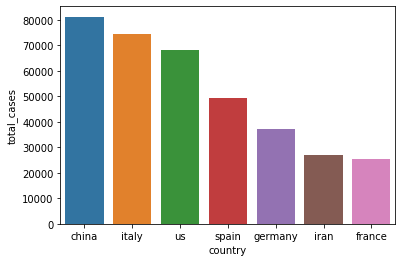

In [35]:
# Se representan gráficamente los resultados
# https://seaborn.pydata.org/generated/seaborn.barplot.html#seaborn.barplot
plot = sns.barplot(x="country", y="total_cases", data=df_last_date)

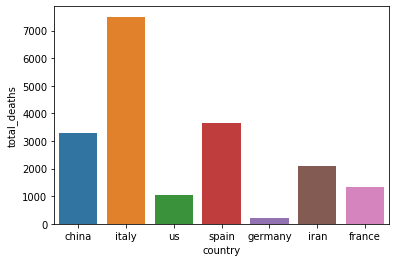

In [36]:
plot = sns.barplot(x="country", y="total_deaths", data=df_last_date)

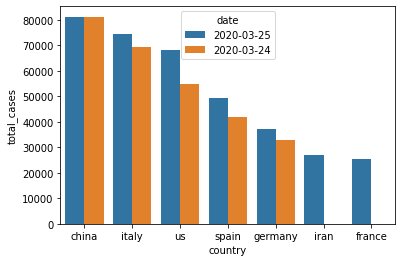

In [37]:
# Se muestra la evolución en el tiempo para cada país ("country")
# Se representan gráficamente los resultados
plot = sns.barplot(x="country", y="total_cases", hue = "date", data=df_significant)

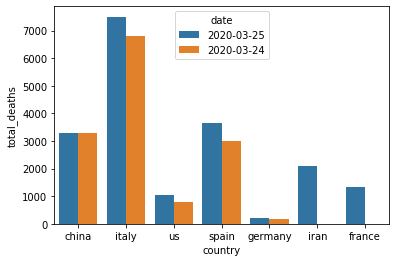

In [38]:
plot = sns.barplot(x="country", y="total_deaths", hue = "date", data=df_significant)

In [39]:
df_spain = df_significant[(df_significant['country'] == 'spain')]

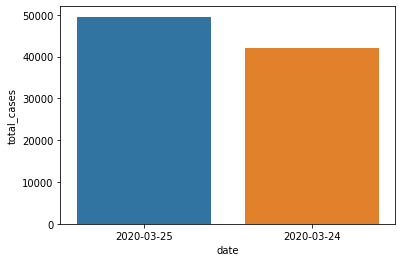

In [40]:
plot = sns.barplot(x='date', y="total_cases", data=df_spain)

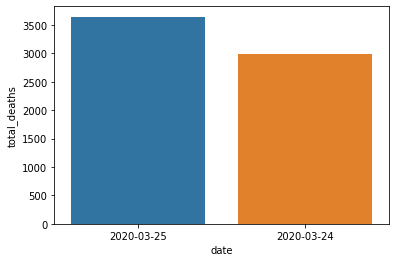

In [41]:
plot = sns.barplot(x='date', y="total_deaths", data=df_spain)